In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import warnings

from joblib import dump, load
from tqdm import tqdm
from pprint import pprint

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
from autosklearn.regression import AutoSklearnRegressor
from autosklearn.metrics import median_absolute_error, mean_absolute_error

warnings.filterwarnings('ignore')

In [2]:
orgs = pd.read_csv('../../data/crunchbase/organizations.csv')
investors = pd.read_csv('../../data/crunchbase/investors.csv')

data = pd.read_csv('../../data/crunchbase/funding_rounds.csv')
data = data[data.raised_amount_usd > 0]
data = data[data.investor_count > 0]
data = data[data.raised_amount_usd > 0]
data = data[data.lead_investor_uuids.notna()]
data = data.drop_duplicates(subset=['uuid'])
data = data[['uuid', 'org_uuid', 'announced_on', 'raised_amount_usd', 'investor_count',
             'investment_type', 'lead_investor_uuids', 'post_money_valuation_usd']]
data.sort_values(by=['org_uuid', 'announced_on'], inplace=True)

In [3]:
def process_group_for_holding_time(group):
    res = group['announced_on'].diff().fillna(group['announced_on'].iloc[0] - group['org_creation'].iloc[0])
    res[res < 0] = 0
    return res

def process_group_for_amount_delta(group):
    return group['raised_amount_usd'].diff().fillna(group['raised_amount_usd'].iloc[0])

In [4]:
ref_date = "1926-01-01"

org_creation = orgs[orgs.uuid.isin(data.org_uuid.unique())][['uuid', 'founded_on']].set_index('uuid')
org_creation = org_creation[org_creation.founded_on > '1700-01-01']
org_creation = (pd.to_datetime(org_creation.founded_on) - pd.Timestamp(ref_date)) // pd.Timedelta('1s')
data = data[data.org_uuid.isin(org_creation.index)]
data["org_creation"] = data.org_uuid.map(org_creation.to_dict())

# transform date into numerical value
data.announced_on = (pd.to_datetime(data.announced_on) - pd.Timestamp(ref_date)) // pd.Timedelta('1s')

# Number of previous rounds
round_count = data[['uuid', 'org_uuid']]
round_count.insert(2, "count", np.ones(data.shape[0]))
round_count = round_count.groupby('org_uuid').cumsum() - 1
data["prev_rounds"] = round_count

# Filter irrelevant round types
data = data[~data.investment_type.isin(['post_ipo_debt', 'post_ipo_equity', 'post_ipo_secondary', 'grant'])]

# Get lead investor rank from Crunchbase
data.lead_investor_uuids = data.lead_investor_uuids.apply(lambda x: x.split(',')[0])
investor_ranks = investors[['uuid', 'rank']].set_index('uuid').to_dict()['rank']
data.lead_investor_uuids = data.lead_investor_uuids.map(investor_ranks)
data.rename(columns={'lead_investor_uuids': 'lead_investor_rank'}, inplace=True)
data.lead_investor_rank.fillna(data.lead_investor_rank.max() + 1, inplace=True)

# Reduce number of values for investment type using frequency
round_freqs = data.investment_type.value_counts() / data.investment_type.size
others = list(round_freqs[round_freqs < 0.01].index.values) + ['series_unknown', 'undisclosed']
data.investment_type = data.investment_type.apply(lambda x: 'other' if x in others else x)

In [5]:
org_country = orgs[orgs.uuid.isin(data.org_uuid.unique())][['uuid', 'country_code']].set_index('uuid').dropna()
data = data[data.org_uuid.isin(org_country.index)]
data["country_code"] = data.org_uuid.map(org_country.to_dict()['country_code'])
country_count = data.groupby('country_code').size()
data.country_code = data.country_code.apply(lambda x: x if country_count[x] > 500 else 'other')

In [6]:
# Time between two rounds. Time from org creation for 1st round
holding_time = pd.Series()
# Amount raised difference between two rounds
amount_delta = pd.Series()

for name, group in tqdm(data.groupby('org_uuid')):
    holding_time = pd.concat([holding_time, process_group_for_holding_time(group)])
    amount_delta = pd.concat([amount_delta, process_group_for_amount_delta(group)])

data['amount_delta'] = amount_delta
data['holding_time'] = holding_time

100%|██████████| 74935/74935 [02:18<00:00, 540.10it/s]


In [7]:
data = data.drop(columns=['org_creation'])
data.columns = ['uuid', 'org_uuid', 'announced_on', 'money_raised_usd', 'num_investors', 'investment_type', 'lead_investor_rank', 'post_money_valuation_usd', 'prev_rounds', 'country_code', 'holding_time', 'amount_delta']

In [8]:
data

,uuid,org_uuid,announced_on,money_raised_usd,num_investors,investment_type,lead_investor_rank,post_money_valuation_usd,prev_rounds,country_code,holding_time,amount_delta
176299,dddc0961-4ac7-42ae-3b70-3ebf960b7ba4,00000aa4-ba42-9b68-a9c3-040c9f3bf9b9,2888784000,8.260736e+07,1.0,other,129869.0,NaN,0.0,DEU,8.260736e+07,774403200.0
143715,e2bc8d8c-7196-0017-3064-60d8b2c80b24,00002470-bff7-6226-5800-0ca1b3787b6f,2870208000,1.600000e+06,1.0,seed,99353.0,NaN,0.0,USA,1.600000e+06,124675200.0
95860,f1e966a7-06d3-f771-fba4-a613a9fbbdb3,000095de-8e2b-82f1-32a7-c222ba3d5682,2380752000,9.500000e+06,1.0,other,195241.0,NaN,0.0,USA,9.500000e+06,13910400.0
473034,aa40a45e-a0bc-455b-85de-125bbc8adc5e,00011be5-d105-eaa0-69d6-6064e74916b2,3036614400,3.667312e+06,8.0,seed,86732.0,NaN,0.0,USA,3.667312e+06,287366400.0
213135,cf936930-f849-4d9a-a007-67cc406ca59f,0001eae7-077d-4d0b-a717-f67bcf2a09fa,2917814400,1.275000e+09,1.0,debt_financing,950.0,NaN,0.0,USA,1.275000e+09,109209600.0
...,...,...,...,...,...,...,...,...,...,...,...,...
333816,4ed08f61-2001-4458-a29e-a651bb1e18be,fffe3b0b-8545-4414-9c0e-a3f961c4e420,2874960000,1.452327e+07,1.0,other,226120.0,NaN,0.0,CHN,1.452327e+07,125280000.0
360045,b6cd618e-c9f0-4410-9f5e-4243b2b65fcd,ffff2bea-7e44-4563-b311-65daadb683cd,2680214400,4.514070e+05,1.0,angel,2679366.0,NaN,0.0,CHN,4.514070e+05,17884800.0
360046,f5cac82f-41b8-4992-abee-ac609fad4e3f,ffff2bea-7e44-4563-b311-65daadb683cd,2755382400,1.616916e+06,1.0,series_a,6752.0,NaN,1.0,CHN,1.165509e+06,75168000.0
132009,d5d0d173-9a6f-4359-f4bb-a7e71f20b988,ffffabce-6d4a-b3d1-13c0-4e90cedf5270,2851804800,2.100000e+05,4.0,seed,34.0,NaN,0.0,USA,2.100000e+05,43200000.0


In [32]:
observed = data[data.post_money_valuation_usd.notna()]
unobserved = data[data.post_money_valuation_usd.isna()]

log_pmv = np.log(observed.post_money_valuation_usd)
observed = observed[(11 < log_pmv) & (log_pmv < 24)]

In [33]:
y = observed.post_money_valuation_usd

In [34]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_percentage_error

def construct_summary_plot(y_train, y_test, y_pred):
    fig = plt.figure(figsize=(15,8))
    gs0 = gridspec.GridSpec(1, 2, figure=fig)
    gs00 = gs0[0].subgridspec(3, 2)
    gs01 = gs0[1].subgridspec(3, 2)

    ax0 = fig.add_subplot(gs00[-1, :-1])
    ax1 = fig.add_subplot(gs00[-1, -1])
    ax2 = fig.add_subplot(gs00[:-1, :])

    ax3 = fig.add_subplot(gs01[-1, :-1])
    ax4 = fig.add_subplot(gs01[-1, -1])
    ax5 = fig.add_subplot(gs01[:-1, :])

    plot_train_and_test_results(ax0, ax1, ax2, y_train, y_test, y_pred)
    plot_train_and_test_results(ax3, ax4, ax5, np.exp(y_train), np.exp(y_test), np.exp(y_pred))
    plt.tight_layout()
    plt.show()

def plot_train_and_test_results(ax0, ax1, ax2, y_train, y_test, y_pred, xlabel='log(PMV)'):
    ax0.hist(y_train, bins=100, label='train')
    ax1.hist(y_pred, bins=100, label='test')

    ax0.set_xlabel(xlabel)
    ax0.set_ylabel('count')
    ax0.set_title('Train')
    ax1.set_xlabel(xlabel)
    ax1.set_title('Test')

    ax2.scatter(y_pred, y_test)
    ax2.plot([y_pred.min(), y_pred.max()], [y_test.min(), y_test.max()], "--k")
    ax2.set_xlabel('predicted')
    ax2.set_ylabel('true')
    ax2.annotate((f"$R^2$={r2_score(y_test, y_pred):.2f}, "
                  f"MAE={-median_absolute_error(y_test, y_pred):.2e}, "
                  f"MAPE={100*mean_absolute_percentage_error(y_test, y_pred):.2f}%"),
                  xy=(0.05, 0.90), xycoords='axes fraction')

In [35]:
def get_model_for_features(features, objective, max_time=3600, full_plot=True):
    X_train, X_test, y_train, y_test = train_test_split(features, objective, test_size=0.33)

    model = AutoSklearnRegressor(
        memory_limit=None,
        metric=mean_absolute_error,
        time_left_for_this_task=max_time)
    model.fit(X_train, y_train, X_test, y_test)

    print(model.sprint_statistics())
    y_pred = model.predict(X_test)
    if full_plot:
        construct_summary_plot(y_train, y_test, y_pred)
    else:
        plt.figure(figsize=(12, 6))
        ax0 = plt.subplot(2,2,1)
        ax1 = plt.subplot(2,2,2)
        ax2 = plt.subplot(2,1,2)
        plot_train_and_test_results(ax0, ax1, ax2, y_train, y_test, y_pred)
    return model

### Absolute model

In [ ]:
X = observed[['announced_on', 'money_raised_usd', 'num_investors', 'lead_investor_rank', 'investment_type', 'holding_time', 'amount_delta']]
X = pd.concat([X.drop(columns='investment_type'), pd.get_dummies(X.investment_type, prefix='rnd_type')], axis=1)

In [ ]:
abs_full = get_model_for_features(X, y, full_plot=False)
dump(abs_full, 'models/abs_full.joblib')

### Log model

In [15]:
X = observed[['announced_on', 'money_raised_usd', 'num_investors', 'lead_investor_rank', 'investment_type', 'holding_time', 'amount_delta']]
X = pd.concat([X.drop(columns='investment_type'), pd.get_dummies(X.investment_type, prefix='rnd_type')], axis=1)

In [ ]:
log_full = get_model_for_features(X, np.log(y))
dump(log_full, 'models/log_full.joblib')

### Whales

In [34]:
late_stage = observed[observed.money_raised_usd >= 2.5e7]
late_unobserved = unobserved[unobserved.money_raised_usd >= 2.5e7]
X = late_stage[['announced_on', 'money_raised_usd', 'num_investors', 'lead_investor_rank', 'investment_type', 'holding_time', 'amount_delta']]
X = pd.concat([X.drop(columns='investment_type'), pd.get_dummies(X.investment_type, prefix='rnd_type')], axis=1)
y = late_stage.post_money_valuation_usd

In [ ]:
late_model = get_model_for_features(X, np.log(y))

### Smallies

In [45]:
early_stage = observed[(observed.money_raised_usd < 2.5e7) & (observed.post_money_valuation_usd < 2.5e8)]
early_unobserved = unobserved[unobserved.money_raised_usd < 2.5e7]
X = early_stage[['announced_on', 'money_raised_usd', 'num_investors', 'lead_investor_rank', 'investment_type', 'holding_time', 'amount_delta']]
X = pd.concat([X.drop(columns='investment_type'), pd.get_dummies(X.investment_type, prefix='rnd_type')], axis=1)
y = early_stage.post_money_valuation_usd

auto-sklearn results:
  Dataset name: 4b34c198-d805-11ec-aff6-acde48001122
  Metric: mean_absolute_error
  Best validation score: 0.526302
  Number of target algorithm runs: 120
  Number of successful target algorithm runs: 101
  Number of crashed target algorithm runs: 17
  Number of target algorithms that exceeded the time limit: 2
  Number of target algorithms that exceeded the memory limit: 0



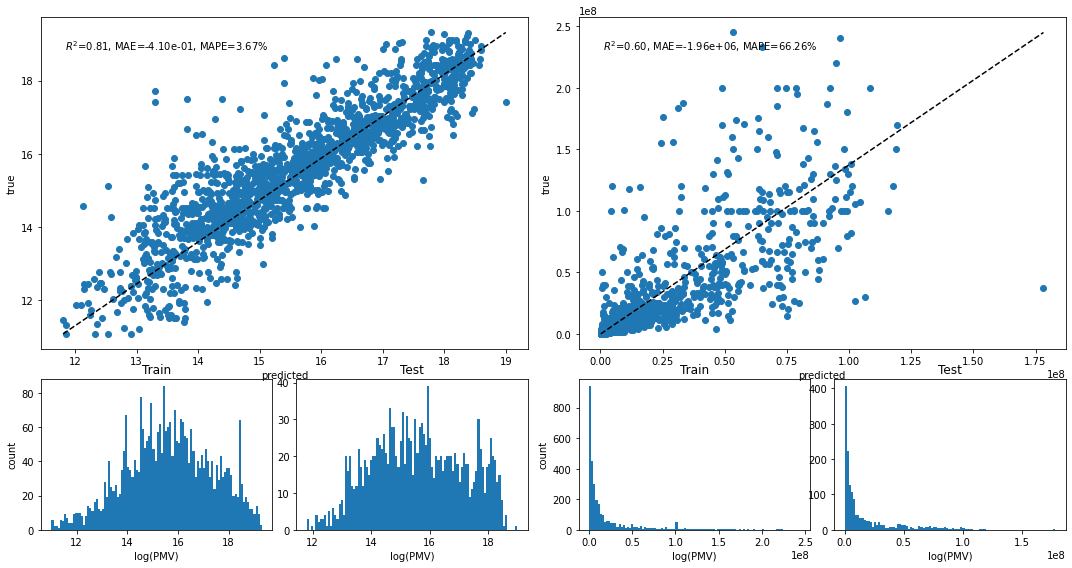

In [29]:
early_model = get_model_for_features(X, np.log(y))
dump(early_model, 'models/early_model.joblib')

### With countries

In [39]:
X = observed[['announced_on', 'money_raised_usd', 'num_investors', 'lead_investor_rank', 'investment_type', 'holding_time', 'amount_delta', 'prev_rounds', 'country_code']]
X = pd.concat([X.drop(columns='investment_type'), pd.get_dummies(X.investment_type, prefix='rnd_type')], axis=1)
X = pd.concat([X.drop(columns='country_code'), pd.get_dummies(X.country_code, prefix='ctry_code')], axis=1)

auto-sklearn results:
  Dataset name: 2c1980f2-db3c-11ec-9edc-acde48001122
  Metric: mean_absolute_error
  Best validation score: 0.525788
  Number of target algorithm runs: 28
  Number of successful target algorithm runs: 16
  Number of crashed target algorithm runs: 4
  Number of target algorithms that exceeded the time limit: 8
  Number of target algorithms that exceeded the memory limit: 0



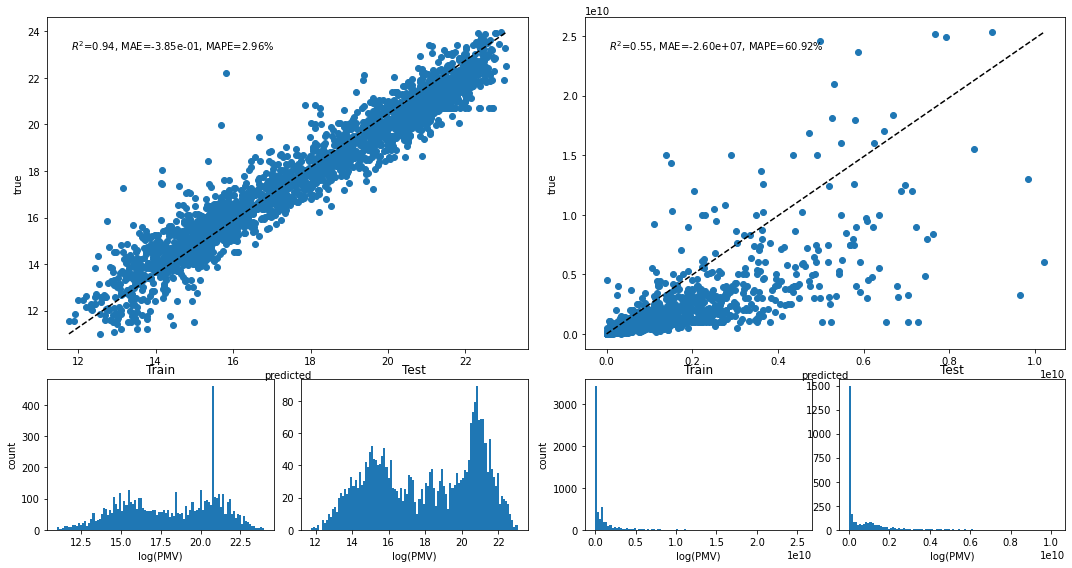

['models/log_full_country.joblib']

In [41]:
log_full_country = get_model_for_features(X, np.log(y))
dump(log_full_country, 'models/log_full_country.joblib')

auto-sklearn results:
  Dataset name: 2e072162-db55-11ec-9edc-acde48001122
  Metric: mean_absolute_error
  Best validation score: 439984654.434393
  Number of target algorithm runs: 28
  Number of successful target algorithm runs: 18
  Number of crashed target algorithm runs: 4
  Number of target algorithms that exceeded the time limit: 6
  Number of target algorithms that exceeded the memory limit: 0



['models/abs_full_country.joblib']

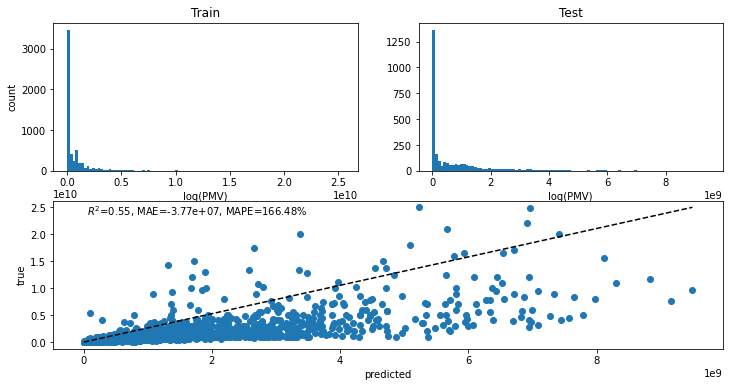

In [42]:
abs_full_country = get_model_for_features(X, y, full_plot=False)
dump(abs_full_country, 'models/abs_full_country.joblib')

In [46]:
X = early_stage[['announced_on', 'money_raised_usd', 'num_investors', 'lead_investor_rank', 'investment_type', 'holding_time', 'amount_delta', 'prev_rounds', 'country_code']]
X = pd.concat([X.drop(columns='investment_type'), pd.get_dummies(X.investment_type, prefix='rnd_type')], axis=1)
X = pd.concat([X.drop(columns='country_code'), pd.get_dummies(X.country_code, prefix='ctry_code')], axis=1)

auto-sklearn results:
  Dataset name: 2d46a0b0-db67-11ec-9edc-acde48001122
  Metric: mean_absolute_error
  Best validation score: 10300552.309021
  Number of target algorithm runs: 74
  Number of successful target algorithm runs: 57
  Number of crashed target algorithm runs: 11
  Number of target algorithms that exceeded the time limit: 6
  Number of target algorithms that exceeded the memory limit: 0



['models/early_full_country.joblib']

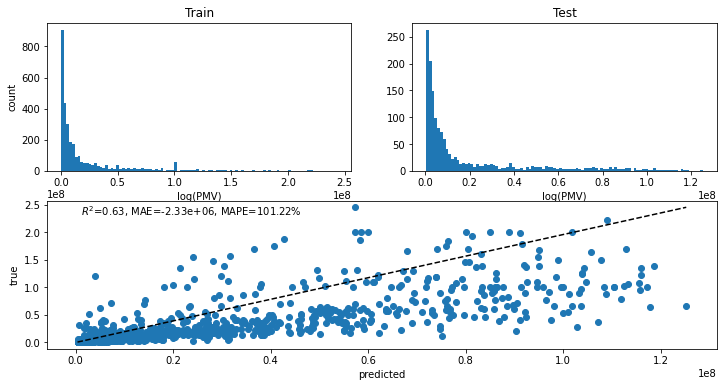

In [47]:
early_full_country = get_model_for_features(X, y, full_plot=False)
dump(early_full_country, 'models/early_full_country.joblib')

### Use model

In [12]:
model = load('models/log_full.joblib')

In [14]:
X = unobserved[['announced_on', 'money_raised_usd', 'num_investors', 'lead_investor_rank', 'investment_type', 'holding_time', 'amount_delta']]
X = pd.concat([X.drop(columns='investment_type'), pd.get_dummies(X.investment_type, prefix='rnd_type')], axis=1)
y_pred = model.predict(X)

In [15]:
unobserved['post_money_valuation_usd'] = np.exp(y_pred)

In [19]:
pd.concat([observed, unobserved], axis=0).to_csv('obs_predicted_data.csv')